In [1]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib  #ajustar
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K

import import_ipynb
from utils import *
from autoencoder_and_clustering_models import *
from read_preprocess_cifar10 import *

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from autoencoder_and_clustering_models.ipynb
importing Jupyter notebook from read_preprocess_cifar10.ipynb


In [2]:
# After download the dataset from  https://www.cs.toronto.edu/~kriz/cifar.html, use these lines to unzip the data
# Change 'arq_path' accordingly
## unzip
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos\cifar-10-python.tar.gz'  # folder where the zipped file is located
#my_tar = tarfile.open(arq_path)
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos'  # specify which folder to extract to
#my_tar.extractall(arq_path) 
#my_tar.close()

In [3]:
model = model_encoder(input_shape=(32,32,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 32, 32, 32)        4736      
_________________________________________________________________
AC_0 (Activation)            (None, 32, 32, 32)        0         
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 16, 16, 16)        12816     
_________________________________________________________________
AC_1 (Activation)            (None, 16, 16, 16)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 16, 16, 16)        6

In [4]:
def my_loss_fn(y_true, y_pred):

    #mse = tf.keras.losses.mean_squared_error(y_true,y_pred, axis=-1)
    #cs = tf.keras.losses.cosine_similarity(y_true,y_pred, axis=-1) + 1
    
        
    mse = tf.keras.losses.MeanSquaredError()
    cs = tf.keras.losses.CosineSimilarity() 
    
    
    return ( mse(y_true, y_pred) + (cs(y_true, y_pred)+1)  )

In [5]:
def train_evaluate(n_epoch, b_size, arq_path):

    
    batch = load_data (arq_path)
    
    train_mse = np.zeros((5))
    train_consineSimilarity = np.zeros((5))
    val_mse = np.zeros((5))
    val_consineSimilarity = np.zeros((5))
    
    for i_crossVal in range(5):

        input_shape = (32, 32, 3)
        model = model_encoder(input_shape=(32,32,3), n_classes=None)
        
        i_train = np.array([w for w in range(5) if not w == i_crossVal])
        
        data_train, data_val, data_test, label_train, label_val, label_test = datasets_crossValitation (batch, i_train, i_crossVal=i_crossVal)


        # Train


        arq_model=arq_path + '\\Encoder_model_'+str(i_crossVal)+'.h5'
        checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        arq_model, 
        monitor='val_loss', 
        mode='min',
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
      
        )
        opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
       # opt = tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07 )
        model.compile(loss = my_loss_fn, optimizer=opt, metrics=['MeanSquaredError', 'cosine_similarity'])
    #    model.compile(loss='mse', optimizer=opt)
        history = model.fit(x=data_train, y=data_train, validation_data=(data_val, data_val), batch_size=b_size, epochs=n_epoch, callbacks=[checkpoint])
    #    model.save(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
  #      plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_loss_'+str(i_crossVal)+'.jpg')
        plt.show()
        
        plt.plot(history.history['MeanSquaredError'])
        plt.plot(history.history['val_MeanSquaredError'])
        plt.title('Model Mean Squared Error')
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Epoch')
        #plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_Mean_Squared_Error_'+str(i_crossVal)+'.jpg')
        plt.show()

        plt.plot(history.history['cosine_similarity'])
        plt.plot(history.history['val_cosine_similarity'])
        plt.title('Model Cosine Similarity')
        plt.ylabel('Cosine Similarity')
        plt.xlabel('Epoch')
        #plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_cosine_similarity_'+str(i_crossVal)+'.jpg')
        plt.show()

        model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', custom_objects={'my_loss_fn': my_loss_fn})
        _, train_mse[i_crossVal], train_consineSimilarity[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
        _, val_mse[i_crossVal], val_consineSimilarity[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
  #      train_loss[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
  #      val_loss[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
    train_mse_mean = np.mean(train_mse)
    val_mse_mean = np.mean(val_mse)
    
    train_mse_std = np.std(train_mse)
    val_mse_std = np.std(val_mse)
    
    train_consineSimilarity_mean = np.mean(train_consineSimilarity)
    val_consineSimilarity_mean = np.mean(val_consineSimilarity)
    
    train_consineSimilarity_std = np.std(train_consineSimilarity)
    val_consineSimilarity_std = np.std(val_consineSimilarity)
    
    
    print('The Mean Train MSE for the Cross-Validation = ', train_mse_mean, ' - with Standard Deviation = ', train_mse_std)
    print('The Mean Validation MSE for the Cross-Validation = ', val_mse_mean, ' - with Standard Deviation = ', val_mse_std)
    
    print('The Mean Train Cosine Similarity for the Cross-Validation = ', train_consineSimilarity_mean, ' - with Standard Deviation = ', train_consineSimilarity_std)
    print('The Mean Validation Cosine Similarity for the Cross-Validation = ', val_consineSimilarity_mean, ' - with Standard Deviation = ', val_consineSimilarity_std)

D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\data_batch_1
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\data_batch_2
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\data_batch_3
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\data_batch_4
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\data_batch_5
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\/test_batch
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\cifar_10_kmeans\cifar-10-batches-py\batches.meta
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 142s 4ms/sample - loss: 0.3052 - MeanSquaredError: 0.1752 - cosine_similarity: 0.8701 - val_loss: 0.2035 - val_MeanSquaredError: 0.1278 - val_cosine_similarity: 0.9242
Epoch 2/70
40000/4

Epoch 34/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0158 - MeanSquaredError: 0.0097 - cosine_similarity: 0.9939 - val_loss: 0.0132 - val_MeanSquaredError: 0.0077 - val_cosine_similarity: 0.9946
Epoch 35/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0157 - MeanSquaredError: 0.0097 - cosine_similarity: 0.9940 - val_loss: 0.0130 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9946
Epoch 36/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0155 - MeanSquaredError: 0.0095 - cosine_similarity: 0.9940 - val_loss: 0.0128 - val_MeanSquaredError: 0.0074 - val_cosine_similarity: 0.9947
Epoch 37/70
40000/40000 [==============================] - 162s 4ms/sample - loss: 0.0154 - MeanSquaredError: 0.0094 - cosine_similarity: 0.9941 - val_loss: 0.0127 - val_MeanSquaredError: 0.0073 - val_cosine_similarity: 0.9947
Epoch 38/70
40000/40000 [==============================] - 151s 4ms/sample - loss: 0.0153 - 

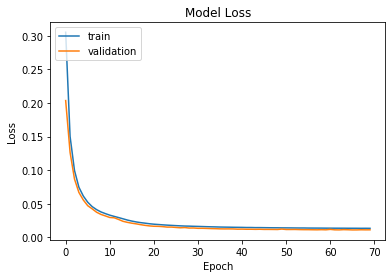

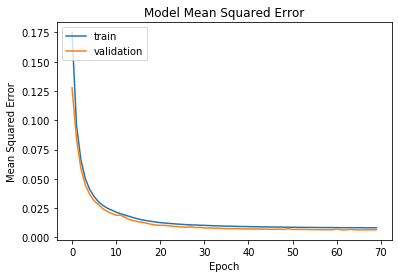

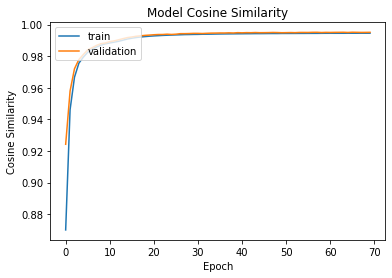

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0112 - MeanSquaredError: 0.0063 - cosine_similarity: 0.9951
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 165s 4ms/sample - loss: 0.1050 - MeanSquaredError: 0.0661 - cosine_similarity: 0.9612 - val_loss: 0.0590 - val_MeanSquaredError: 0.0386 - val_cosine_similarity: 0.9796
Epoch 2/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0547 - MeanSquaredError: 0.0351 - cosine_similarity: 0.9804 - val_loss: 0.0477 - val_MeanSquaredError: 0.0295 - val_cosine_similarity: 0.9818
Epoch 3/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0472 - MeanSquaredError: 0.0298 - cosine_similarity: 0.9826 - val_loss: 0.0421 - val_MeanSquaredError: 0.0257 - val_cosine_similarity: 0.9836
Epoch 4/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0422 - MeanSquaredError: 0.0264 - cosine_similarity: 0.9

Epoch 36/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0163 - MeanSquaredError: 0.0101 - cosine_similarity: 0.9938 - val_loss: 0.0135 - val_MeanSquaredError: 0.0080 - val_cosine_similarity: 0.9945
Epoch 37/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0162 - MeanSquaredError: 0.0100 - cosine_similarity: 0.9938 - val_loss: 0.0135 - val_MeanSquaredError: 0.0079 - val_cosine_similarity: 0.9944
Epoch 38/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0160 - MeanSquaredError: 0.0099 - cosine_similarity: 0.9939 - val_loss: 0.0128 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9947
Epoch 39/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0163 - MeanSquaredError: 0.0100 - cosine_similarity: 0.9937 - val_loss: 0.0133 - val_MeanSquaredError: 0.0078 - val_cosine_similarity: 0.9945
Epoch 40/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0161 - 

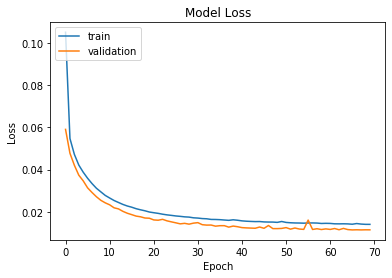

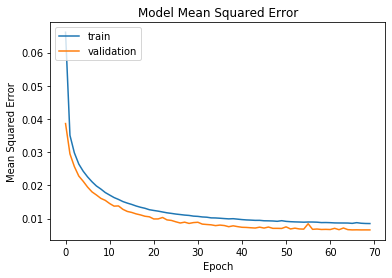

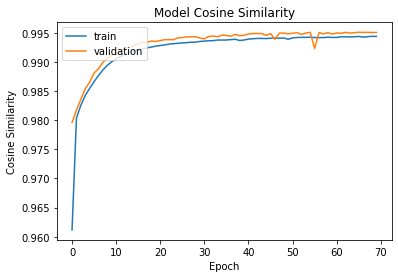

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0115 - MeanSquaredError: 0.0066 - cosine_similarity: 0.9951
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 164s 4ms/sample - loss: 0.1164 - MeanSquaredError: 0.0674 - cosine_similarity: 0.9510 - val_loss: 0.0613 - val_MeanSquaredError: 0.0401 - val_cosine_similarity: 0.9787
Epoch 2/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0552 - MeanSquaredError: 0.0364 - cosine_similarity: 0.9812 - val_loss: 0.0479 - val_MeanSquaredError: 0.0301 - val_cosine_similarity: 0.9822
Epoch 3/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0475 - MeanSquaredError: 0.0307 - cosine_similarity: 0.9832 - val_loss: 0.0425 - val_MeanSquaredError: 0.0272 - val_cosine_similarity: 0.9846
Epoch 4/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0426 - MeanSquaredError: 0.0277 - cosine_similarity: 0.9

Epoch 36/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0165 - MeanSquaredError: 0.0103 - cosine_similarity: 0.9938 - val_loss: 0.0146 - val_MeanSquaredError: 0.0088 - val_cosine_similarity: 0.9943
Epoch 37/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0167 - MeanSquaredError: 0.0104 - cosine_similarity: 0.9937 - val_loss: 0.0146 - val_MeanSquaredError: 0.0090 - val_cosine_similarity: 0.9944
Epoch 38/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0165 - MeanSquaredError: 0.0103 - cosine_similarity: 0.9938 - val_loss: 0.0138 - val_MeanSquaredError: 0.0083 - val_cosine_similarity: 0.9945
Epoch 39/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0162 - MeanSquaredError: 0.0101 - cosine_similarity: 0.9939 - val_loss: 0.0135 - val_MeanSquaredError: 0.0080 - val_cosine_similarity: 0.9945
Epoch 40/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0161 - 

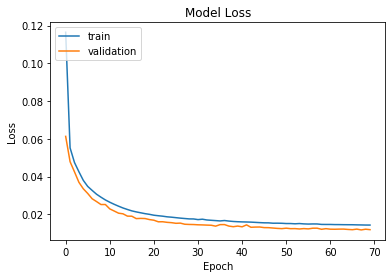

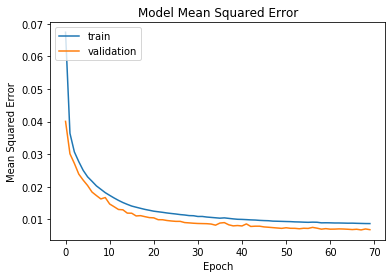

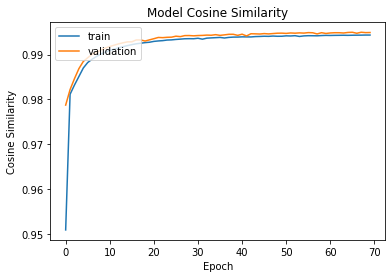

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0118 - MeanSquaredError: 0.0067 - cosine_similarity: 0.9950
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 165s 4ms/sample - loss: 0.1125 - MeanSquaredError: 0.0644 - cosine_similarity: 0.9520 - val_loss: 0.0610 - val_MeanSquaredError: 0.0404 - val_cosine_similarity: 0.9794
Epoch 2/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0559 - MeanSquaredError: 0.0365 - cosine_similarity: 0.9805 - val_loss: 0.0472 - val_MeanSquaredError: 0.0308 - val_cosine_similarity: 0.9836
Epoch 3/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0450 - MeanSquaredError: 0.0293 - cosine_similarity: 0.9843 - val_loss: 0.0387 - val_MeanSquaredError: 0.0246 - val_cosine_similarity: 0.9860
Epoch 4/70
40000/40000 [==============================] - 164s 4ms/sample - loss: 0.0393 - MeanSquaredError: 0.0255 - cosine_similarity: 0.9

Epoch 36/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0170 - MeanSquaredError: 0.0106 - cosine_similarity: 0.9935 - val_loss: 0.0137 - val_MeanSquaredError: 0.0082 - val_cosine_similarity: 0.9945
Epoch 37/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0169 - MeanSquaredError: 0.0105 - cosine_similarity: 0.9936 - val_loss: 0.0137 - val_MeanSquaredError: 0.0084 - val_cosine_similarity: 0.9947
Epoch 38/70
40000/40000 [==============================] - 159s 4ms/sample - loss: 0.0172 - MeanSquaredError: 0.0107 - cosine_similarity: 0.9934 - val_loss: 0.0137 - val_MeanSquaredError: 0.0083 - val_cosine_similarity: 0.9946
Epoch 39/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0173 - MeanSquaredError: 0.0107 - cosine_similarity: 0.9934 - val_loss: 0.0140 - val_MeanSquaredError: 0.0085 - val_cosine_similarity: 0.9945
Epoch 40/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0171 - 

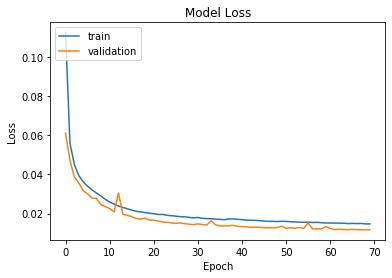

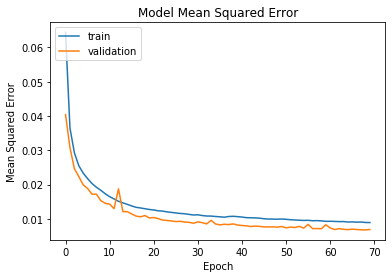

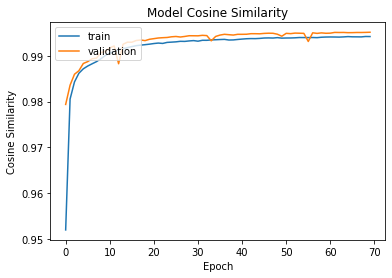

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0117 - MeanSquaredError: 0.0067 - cosine_similarity: 0.9951
Train on 40000 samples, validate on 10000 samples
Epoch 1/70
40000/40000 [==============================] - 160s 4ms/sample - loss: 0.1023 - MeanSquaredError: 0.0619 - cosine_similarity: 0.9596 - val_loss: 0.0537 - val_MeanSquaredError: 0.0352 - val_cosine_similarity: 0.9815
Epoch 2/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0503 - MeanSquaredError: 0.0329 - cosine_similarity: 0.9826 - val_loss: 0.0452 - val_MeanSquaredError: 0.0282 - val_cosine_similarity: 0.9830
Epoch 3/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0434 - MeanSquaredError: 0.0275 - cosine_similarity: 0.9841 - val_loss: 0.0392 - val_MeanSquaredError: 0.0239 - val_cosine_similarity: 0.9846
Epoch 4/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0387 - MeanSquaredError: 0.0244 - cosine_similarity: 0.9

Epoch 36/70
40000/40000 [==============================] - 157s 4ms/sample - loss: 0.0159 - MeanSquaredError: 0.0099 - cosine_similarity: 0.9940 - val_loss: 0.0130 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9946
Epoch 37/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0159 - MeanSquaredError: 0.0099 - cosine_similarity: 0.9940 - val_loss: 0.0130 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9945
Epoch 38/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0158 - MeanSquaredError: 0.0099 - cosine_similarity: 0.9940 - val_loss: 0.0133 - val_MeanSquaredError: 0.0075 - val_cosine_similarity: 0.9942
Epoch 39/70
40000/40000 [==============================] - 164s 4ms/sample - loss: 0.0156 - MeanSquaredError: 0.0096 - cosine_similarity: 0.9941 - val_loss: 0.0132 - val_MeanSquaredError: 0.0076 - val_cosine_similarity: 0.9944
Epoch 40/70
40000/40000 [==============================] - 163s 4ms/sample - loss: 0.0155 - 

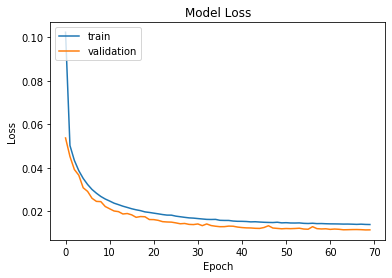

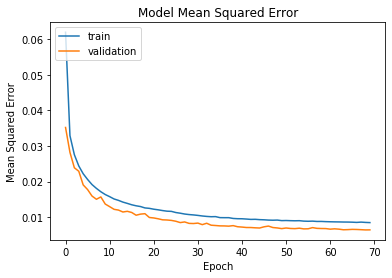

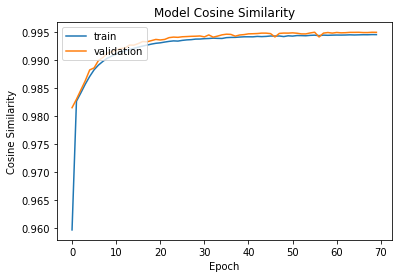

10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0115 - MeanSquaredError: 0.0064 - cosine_similarity: 0.9949
The Mean Train MSE for the Cross-Validation =  0.006532505340874195  - with Standard Deviation =  0.00015772800503710237
The Mean Validation MSE for the Cross-Validation =  0.006561236362904311  - with Standard Deviation =  0.00016867034087800166
The Mean Train Cosine Similarity for the Cross-Validation =  0.9950833797454834  - with Standard Deviation =  0.00012091167586999165
The Mean Validation Cosine Similarity for the Cross-Validation =  0.9950409412384034  - with Standard Deviation =  8.194397832399831e-05


In [6]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
train_evaluate(n_epoch=70, b_size=32, arq_path = arq_path)

D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_1
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_2
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_3
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_4
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_5
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\/test_batch
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\batches.meta


<Figure size 432x288 with 0 Axes>

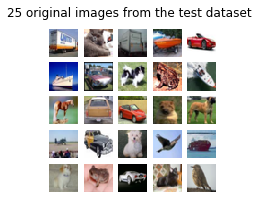

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

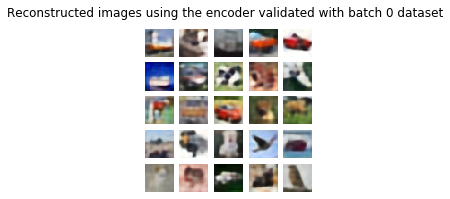

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0112 - MeanSquaredError: 0.0063 - cosine_similarity: 0.9951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

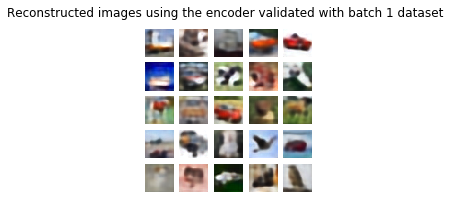

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0116 - MeanSquaredError: 0.0065 - cosine_similarity: 0.9949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

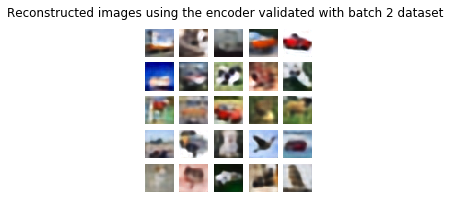

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0118 - MeanSquaredError: 0.0067 - cosine_similarity: 0.9949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

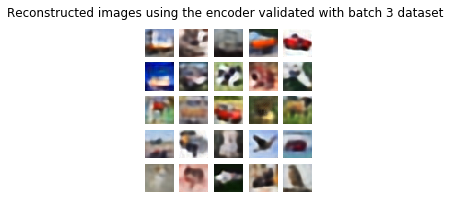

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0120 - MeanSquaredError: 0.0068 - cosine_similarity: 0.9948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

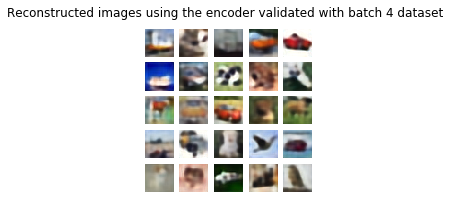

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.0115 - MeanSquaredError: 0.0065 - cosine_similarity: 0.9950
The Mean Test MSE for the Cross-Validation =  0.006554782018065452  - with Standard Deviation =  0.0001611866449091151
The Mean Test Cosine Similarity for the Cross-Validation =  0.9949243426322937  - with Standard Deviation =  9.164714198696537e-05


In [6]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
batch = load_data (arq_path)
    
i_train = np.arange(5)
    
data_train, data_val, data_test, label_train, label_val, label_test = datasets_crossValitation (batch, i_train, i_crossVal=0)

i = np.random.choice(range(len(data_test)),25)

t=0
plt.figure()
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
i_aux=np.zeros((5,5))
for j in range(5):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(data_test[i[t]])
        t+=1
fig.suptitle('25 original images from the test dataset')
plt.show()  
    
test_mse = np.zeros((5))
test_consineSimilarity = np.zeros((5))

for i_crossVal in range(5):
    
   
    model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', custom_objects={'my_loss_fn': my_loss_fn})
    
    
    y_hat=model.predict( data_test[i] )

    t=0
    plt.figure()
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(y_hat[t])
            t+=1
    fig.suptitle('Reconstructed images using the encoder validated with batch ' + str(i_crossVal) + ' dataset')
    plt.show()
    _, test_mse[i_crossVal], test_consineSimilarity[i_crossVal] = model.evaluate(x=data_test, y=data_test, batch_size=128)
            
test_mse_mean = np.mean(test_mse)
test_mse_std = np.std(test_mse)

test_consineSimilarity_mean = np.mean(test_consineSimilarity)
test_consineSimilarity_std = np.std(test_consineSimilarity)

print('The Mean Test MSE for the Cross-Validation = ', test_mse_mean, ' - with Standard Deviation = ', test_mse_std)
print('The Mean Test Cosine Similarity for the Cross-Validation = ', test_consineSimilarity_mean, ' - with Standard Deviation = ', test_consineSimilarity_std)
    
       
